In [1]:
%reload_ext autoreload
import GCNN
import pkgutil
from GCNN.group import CyclicGroup

# We demonstrate our models on the MNIST dataset.
import torchvision
import torch
DATASET_PATH = './data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We normalize the training data.
train_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                  ])

# To demonstrate the generalization capabilities our rotation equivariant layers bring, we apply a random
# rotation between 0 and 360 deg to the test set.
test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.RandomRotation(
                                                     [0, 360],
                                                     torchvision.transforms.InterpolationMode.BILINEAR,
                                                     fill=0),
                                                 torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                 ])

train_ds = torchvision.datasets.MNIST(root=DATASET_PATH, train=True, transform=train_transform, download=True)
test_ds = torchvision.datasets.MNIST(root=DATASET_PATH, train=False, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=8)
digit, label = train_ds[140]

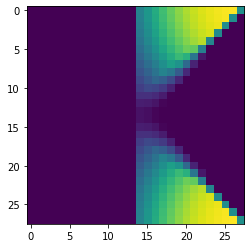

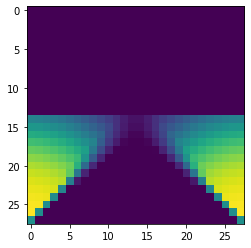

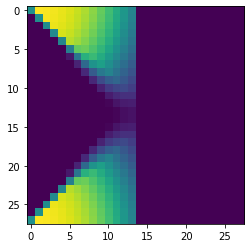

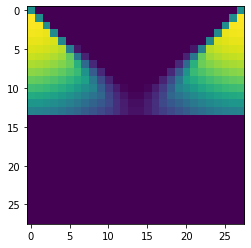

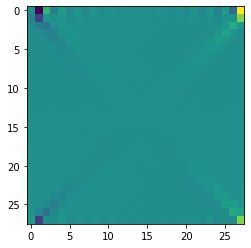

AssertionError: 

In [3]:
# import GCNN.train as train
from torchvision import transforms
import matplotlib.pyplot as plt
from WaveletLiftingLayer import WaveletLiftingLayer
from GCNN.gcnn import GroupConvolution, LiftingConvolution
%reload_ext autoreload
def rotate_tensor(tensor, angle):
    return torchvision.transforms.functional.rotate(tensor, angle, torchvision.transforms.functional.InterpolationMode.BILINEAR)
slices = 4
lift = WaveletLiftingLayer(resolution=(28,28),wavelet_type='smooth',slices=slices)
# Get an image from the test dataset.


# Turn it into a tensor.
plt.imshow(digit.squeeze(),vmax = 1, vmin=0, cmap='gray')
plt.show()

# Get a set of angles by which to rotate this image.
rots = torch.linspace(0, 360 - 360/slices, slices)
print(rots)
# Rotate the input image and push it through the normalization transform.
rot_digit = torch.stack(tuple(torchvision.transforms.functional.rotate(digit, a.item(), torchvision.transforms.functional.InterpolationMode.BILINEAR) for a in rots))
rot_digit = torchvision.transforms.Normalize((0.1307,), (0.3081,))(rot_digit)
# conv = GroupConvolution(CyclicGroup(4), 1, 1, 3)
reg_lift = LiftingConvolution(
            group=CyclicGroup(slices),
            in_channels=1,
            out_channels=1,
            kernel_size=3,
        )
fig, ax = plt.subplots(1, slices, figsize=(40, 10))
for i,dig in enumerate(rot_digit):
    lifted = lift(dig.unsqueeze(0)).detach()
    lifted = lifted.squeeze()
    lifted = rotate_tensor(torch.real(lifted[i]).unsqueeze(0), -360/slices*i).squeeze()
    ax[i].imshow(lifted)
    # ax[i].set_title(f'Filter {i}')
fig.show()


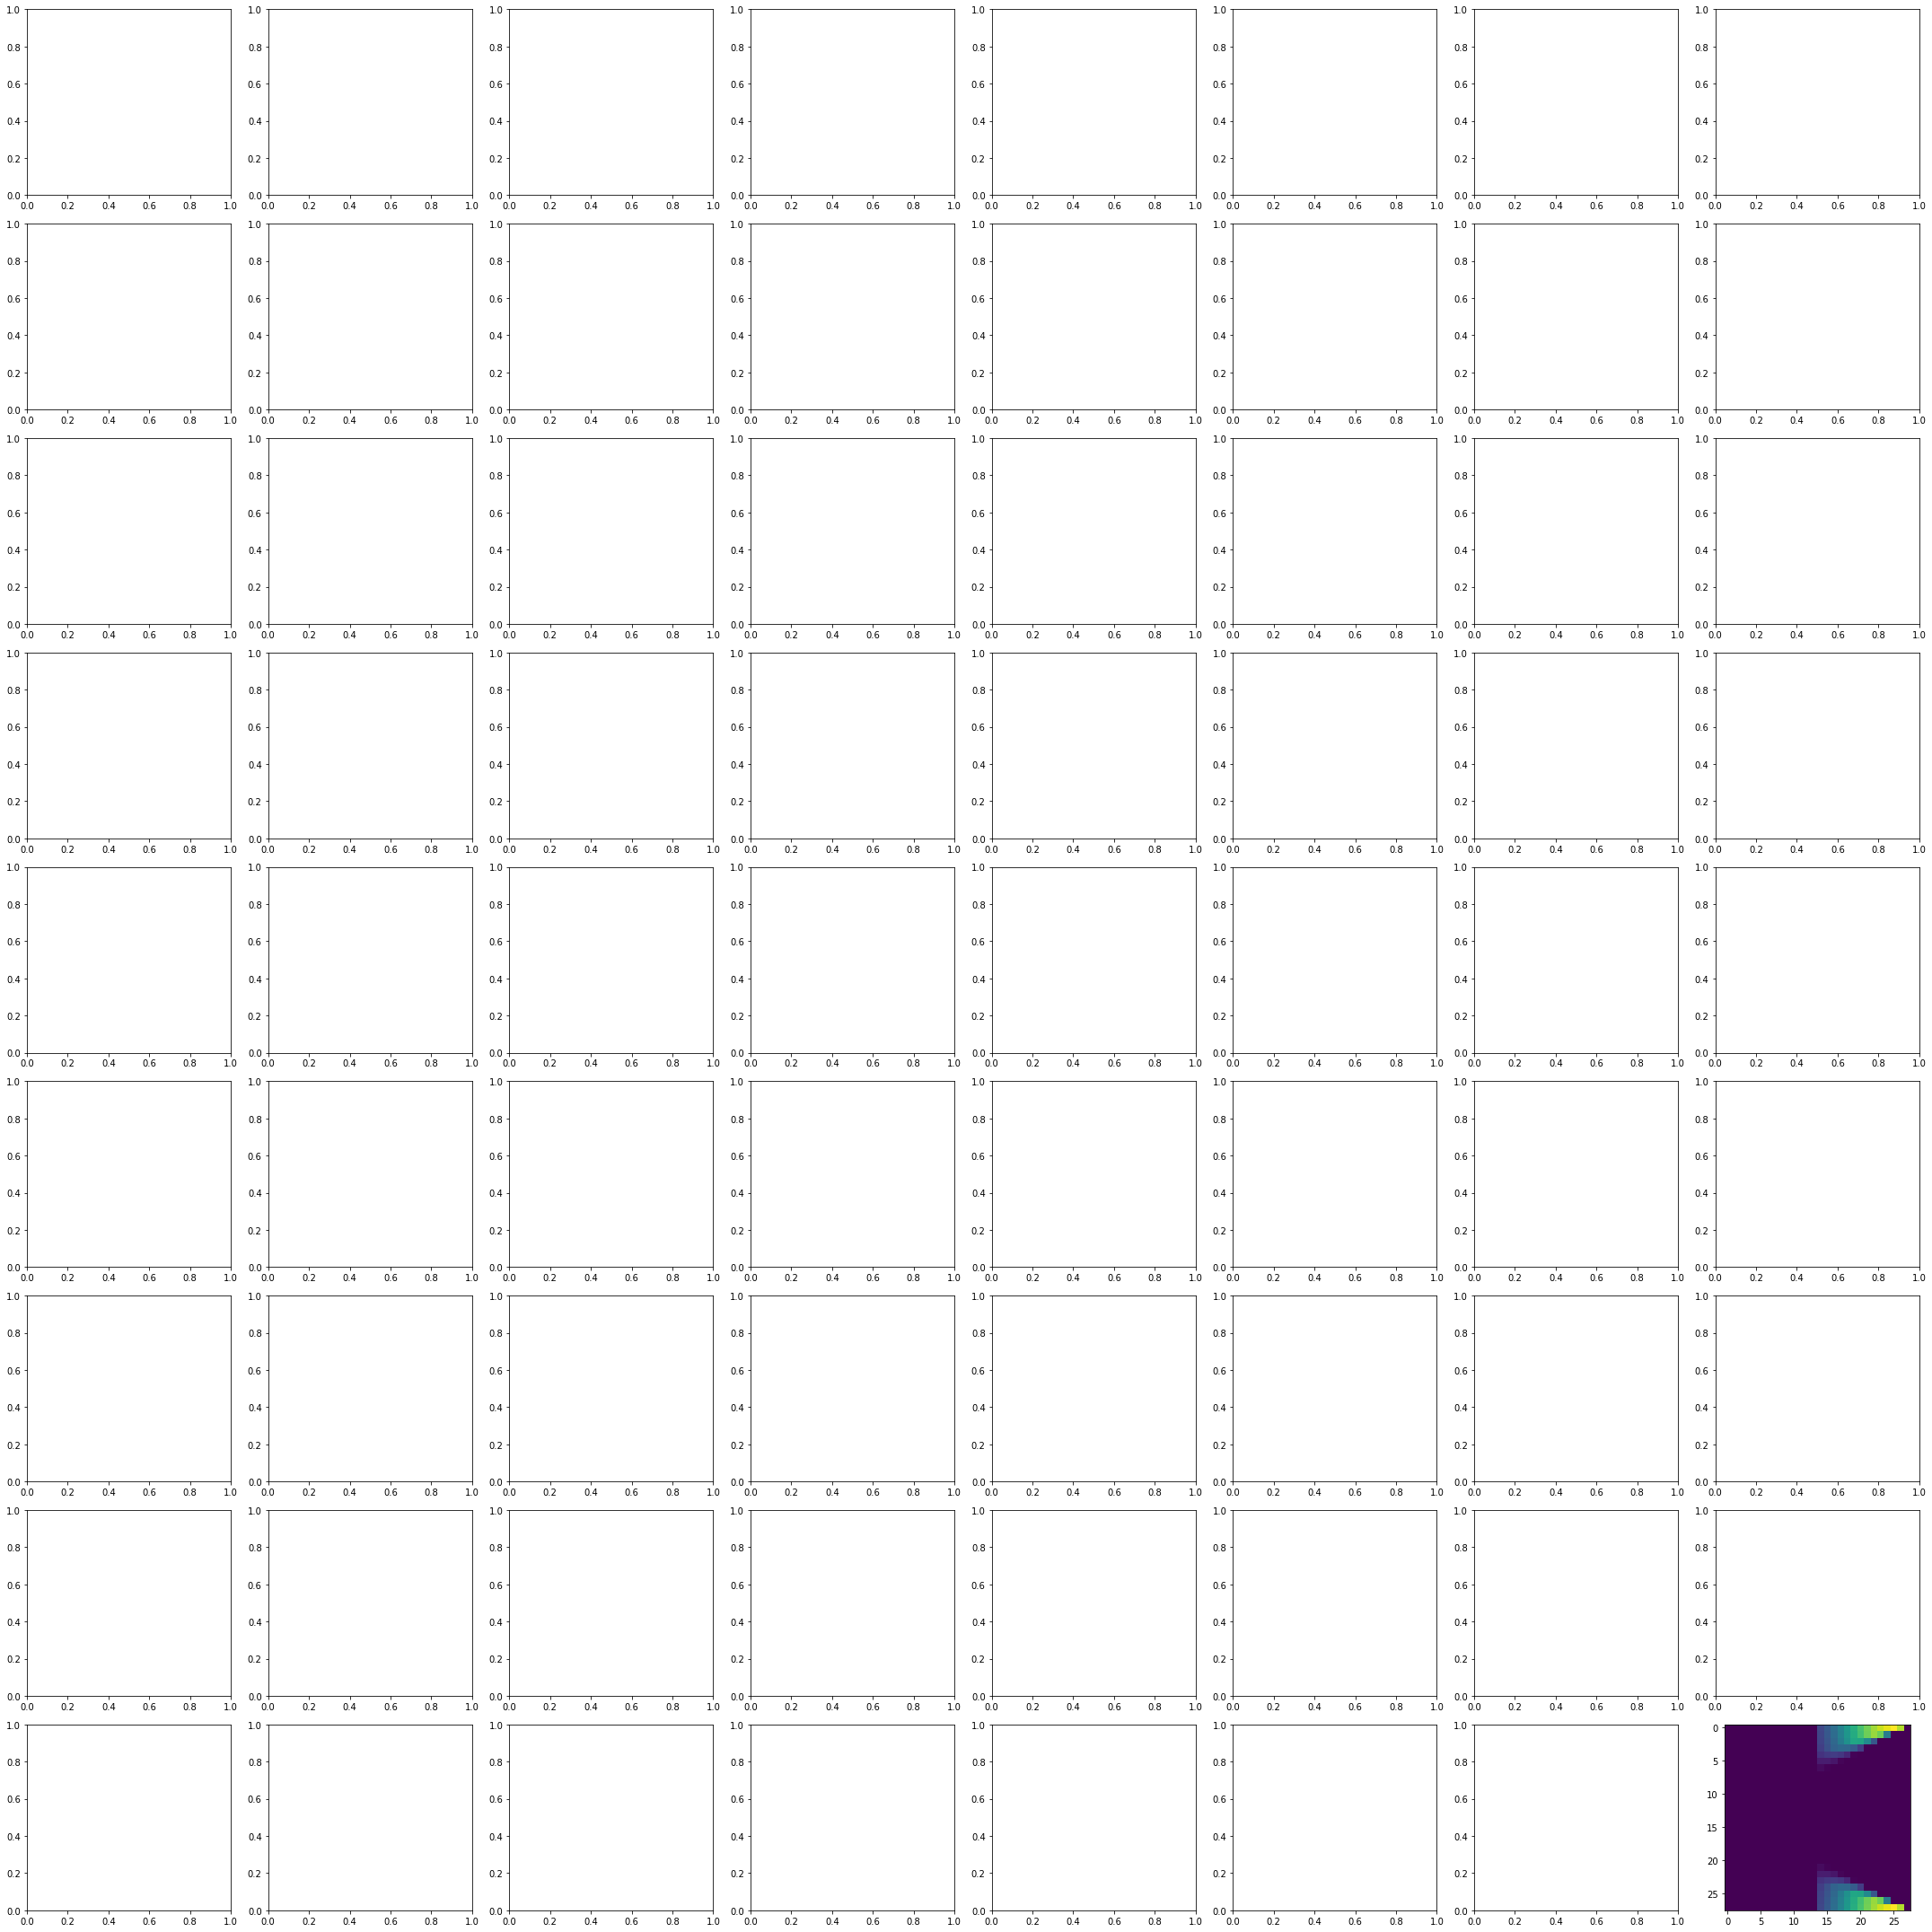

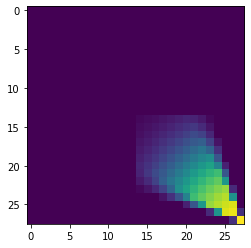

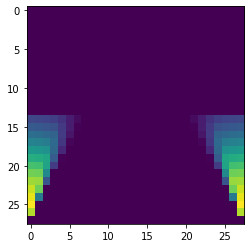

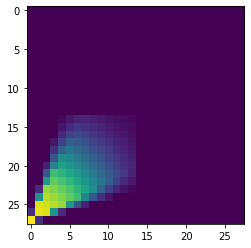

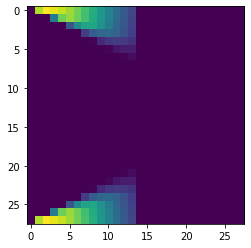

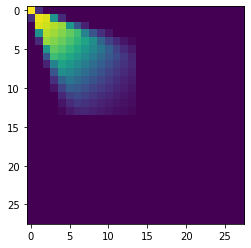

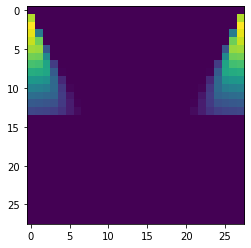

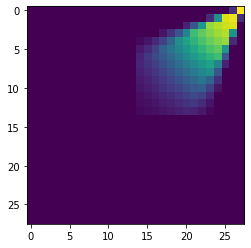

In [4]:
fig, ax = plt.subplots(slices+1,slices, figsize=(30,30))
fig.tight_layout()

layer = WaveletLiftingLayer(slices,(rot_digit.shape[-1], rot_digit.shape[-2]), wavelet_type='smooth')
import PIL.ImageOps as ImageOps
for i,x_rot in enumerate(rot_digit):
    x_rot = x_rot.unsqueeze(0)
    y = layer(x_rot).detach()
    for f in range(slices):
        one_filter = torch.real(y[0,:,f,:,:]).permute(1,2,0).squeeze()
        ax[f][i].imshow((one_filter))
        ax[f][i].axis('off')
    ax[-1][i].imshow(x_rot[0].permute(1,2,0).squeeze())
ax[0][slices//2-1].title.set_text('Cake Filter')
ax[-1][slices//2-1].title.set_text('Original')
[a.axis('off') for a in ax[-1]]
fig.tight_layout()
plt.show()

In [3]:
import matplotlib.pyplot as plt
rots = torch.linspace(0, 360 - 360/8, 8)

plt.rcParams['figure.figsize'] = [10, 9]

# Pick a channel to visualize
channel_idx = 2

# Create a subfigure for every rotated input and every group element
fig, ax = plt.subplots(gcnn_out.shape[2], rots.numel())

for idx, rotation in enumerate(rots):
    for group_element_idx in range(gcnn_out.shape[2]):
        ax[group_element_idx ,idx].imshow(
            gcnn_out[idx, out_channel_idx, group_element_idx, :, :].detach().numpy()
        )
    ax[0, idx].set_title(f"{int(rotation)} deg")
    

fig.text(0.5, 0.04, 'Rotations of input image', ha='center')
fig.text(0.04, 0.5, '$H$ dimension in feature map', va='center', rotation='vertical')

plt.show()

NameError: name 'gcnn_out' is not defined

In [4]:
# for images, labels in train_loader:
#     print(images.shape)
#     i = net(images)
#     break

In [7]:
import pytorch_lightning as pl

class DataModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
        optimizer = optim.AdamW(
            self.parameters(), **self.hparams.optimizer_hparams)
        return [optimizer], []

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc, prog_bar=True)

model_dict = {
    'Cake_GCNN': GCNN.gcnn.Cake_GroupEquivariantCNN,
    'GCNN': GCNN.gcnn.GroupEquivariantCNN
}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

In [8]:
import os
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import torch.nn as nn 
import torch.optim as optim
from pytorch_lightning import loggers as pl_loggers

CHECKPOINT_PATH = './checkpoints'

def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    logger = pl_loggers.TensorBoardLogger(save_dir="logs/")

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         gpus=1 if str(device)=="cuda:0" else 0,                                             # We run on a single GPU (if possible)
                         max_epochs=10,                                                                      # How many epochs to train for if no patience is set
                        #  callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                        #             LearningRateMonitor("epoch")],
                        #  logger=comet_logger,
                        logger=logger
                        )
    # trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = DataModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(12) # To be reproducable
        model = DataModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DataModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on test set
    val_result = trainer.test(model.to(device), test_loader, verbose=False)
    result = {"val": val_result[0]["test_acc"]}

    return model, result

In [9]:
net = train_model(  model_name="Cake_GCNN",
                    model_hparams={'group':CyclicGroup(4), 
                                'in_channels':1, 
                                'out_channels':10, 
                                'kernel_size':3, 
                                'hidden_dims':[32,16,16,16],  
                                'resolution':(28,28), 
                                'wavelet_type':'smooth', 
                                'slices':4},
                    optimizer_name="Adam",
                    optimizer_hparams={"lr": 1e-2,
                                        "weight_decay": 1e-4},
                    save_name='cnn-pretrained')

# gcnn_model, gcnn_results = train_model(model_name="GCNN",
#                                        model_hparams={"in_channels": 1,
#                                                       "out_channels": 10,
#                                                       "kernel_size": 5,
#                                                       "num_hidden": 4,
#                                                       "hidden_channels":16, # to account for the increase in trainable parameters due to the extra dimension in our feature maps, remove some hidden channels.
#                                                       "group":CyclicGroup(order=4).to(device)},
#                                        optimizer_name="Adam",
#                                        optimizer_hparams={"lr": 1e-2,
#                                                           "weight_decay": 1e-4},
#                                        save_name='gcnn-pretrained')

c:\Users\Chase\AppData\Local\Continuum\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 12
Missing logger folder: logs/lightning_logs

  | Name        | Type                     | Params
---------------------------------------------------------
0 | model       | Cake_GroupEquivariantCNN | 38.2 K
1 | loss_module | CrossEntropyLoss         | 0     
---------------------------------------------------------
38.2 K    Trainable params
0         Non-trainable params
38.2 K    Total params
0.153     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

c:\Users\Chase\AppData\Local\Continuum\anaconda3\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Testing: 0it [00:00, ?it/s]

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 22151168 bytes.

CometLogger will be initialized in offline mode
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 12
c:\Users\Chase\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

  | Name        | Type                     | Params
---------------------------------------------------------
0 | model       | Cake_GroupEquivariantCNN | 38.2 K
1 | loss_module | CrossEntropyLoss         | 0     
---------------------------------------------------------
38.2 K    Trainable params
0         Non-trainable params
38.2 K    Total params
0.153     Total estimated mod

Sanity Checking: 0it [00:00, ?it/s]

c:\Users\Chase\AppData\Local\Continuum\anaconda3\lib\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


: 

In [2]:
from GCNN_Entropy_Min.entropy_model import train
train()

CometLogger will be initialized in offline mode
c:\Users\Chase\AppData\Local\Continuum\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 12


{'group': CyclicGroup(), 'in_channels': 1, 'kernel_size': 14}


ValueError: optimizer got an empty parameter list